In this jupyter notebook we call the different algorithms to provide the numerical tests mentioned in the study

In [33]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table


import module.euler_scheme
import module.markovian_case
import module.path_dependent_case

In [6]:
# simple function to convert time into hours, minutes, and seconds
def convert_to_hms(seconds):
    whole_seconds = int(seconds)
    fractional_seconds = seconds - whole_seconds

    time_delta = datetime.timedelta(seconds=whole_seconds)

    hours, remainder = divmod(time_delta.seconds, 3600)
    minutes, whole_seconds = divmod(remainder, 60)

    precise_seconds = round(whole_seconds + fractional_seconds, 6)

    result = ""
    if hours > 0:
        result += f"{hours}h "
    if minutes > 0 or hours > 0:  # Include minutes if there are hours
        result += f"{minutes}min "
    result += f"{precise_seconds}s"

    return result.strip()

TEST for V_0 in (4.2) from [Unbiased simulation of stochastic differential equations](https://arxiv.org/abs/1504.06107)

expected result : 0.205396 around

In [7]:
# Parameters

X0 = 0  # Initial value
T = 1   # Maturity
nDim = 1    # Dim of process
mSteps = 10     # Number of time steps in Euler Scheme
nSamples = 10**5   # Number of simulations of MC

K = 1   # Strike
Sigma0 = 0.5
Beta = 0.1  # Beta constant
M = 4   # M constant

lTimeIntervals = [0, T]

In [8]:
# μ in the provided SDE
def funcMu(t, x):
    return 0.1 * (np.sqrt(np.exp(x)) - 1) - 0.125

# Payoff G in the provided example (Call option)
def funcG(x):
    return np.maximum(0, np.exp(x) - K)

# Payoff G in the provided example (Call option) for the Path Dependent Case
def funcG_PathDep(x):
    return np.maximum(0, np.exp(x[-1]) - K)

Run The Simulations

In [11]:
start_time = time.time()
estimator, confidence_interval, error = euler_scheme.MC_estimator_EulerScheme_Markovian(funcG, X0, funcMu, Sigma0, T, nDim, mSteps, nSamples)
print("Estimator MC_estimator_EulerScheme_Markovian:", estimator)
print("95% Confidence Interval MC_EulerScheme_Markovian:", confidence_interval)
print("Standard Error MC_EulerScheme_Markovian:", error)
print(f"Execution time: {time.time() - start_time} seconds")

Estimator MC_estimator_EulerScheme_Markovian: 0.20721759003853174
95% Confidence Interval MC_EulerScheme_Markovian: [0.20462208255279002, 0.20981309752427346]
Standard Error MC_EulerScheme_Markovian: 0.001324238513133528
Execution time: 4.79671311378479 seconds


In [12]:
start_time = time.time()
estimator, confidence_interval, error = markovian_case.MC_estimator(funcG, X0, funcMu, Sigma0, Beta, T, nDim, nSamples)
print("Estimator US_Markovian_Case:", estimator)
print("95% Confidence Interval US_Markovian_Case:", confidence_interval)
print("Standard Error US_Markovian_Case:", error)
print(f"Execution time: {time.time() - start_time} seconds")

Estimator US_Markovian_Case: 0.20767421917944515
95% Confidence Interval US_Markovian_Case: [0.2049078516989868, 0.2104405866599035]
Standard Error US_Markovian_Case: 0.001411411979825694
Execution time: 1.3522882461547852 seconds


In [ ]:
start_time = time.time()
estimator, confidence_interval, error = path_dependent_case.MC_estimator(funcG_PathDep, X0, funcMu, Sigma0, Beta, lTimeIntervals, nSamples)
print("Estimator US_Path_Dependent_Case:", estimator)
print("95% Confidence Interval US_Path_Dependent_Case:", confidence_interval)
print("Standard Error US_Path_Dependent_Case:", error)
print(f"Execution time: {time.time() - start_time} seconds")

Estimator US_Path_Dependent_Case: 0.2044116973156555
95% Confidence Interval US_Path_Dependent_Case: [0.20164000227511544, 0.20718339235619557]
Standard Error US_Path_Dependent_Case: 0.0014141301227245185
Execution time: 1.4628493785858154 seconds
 


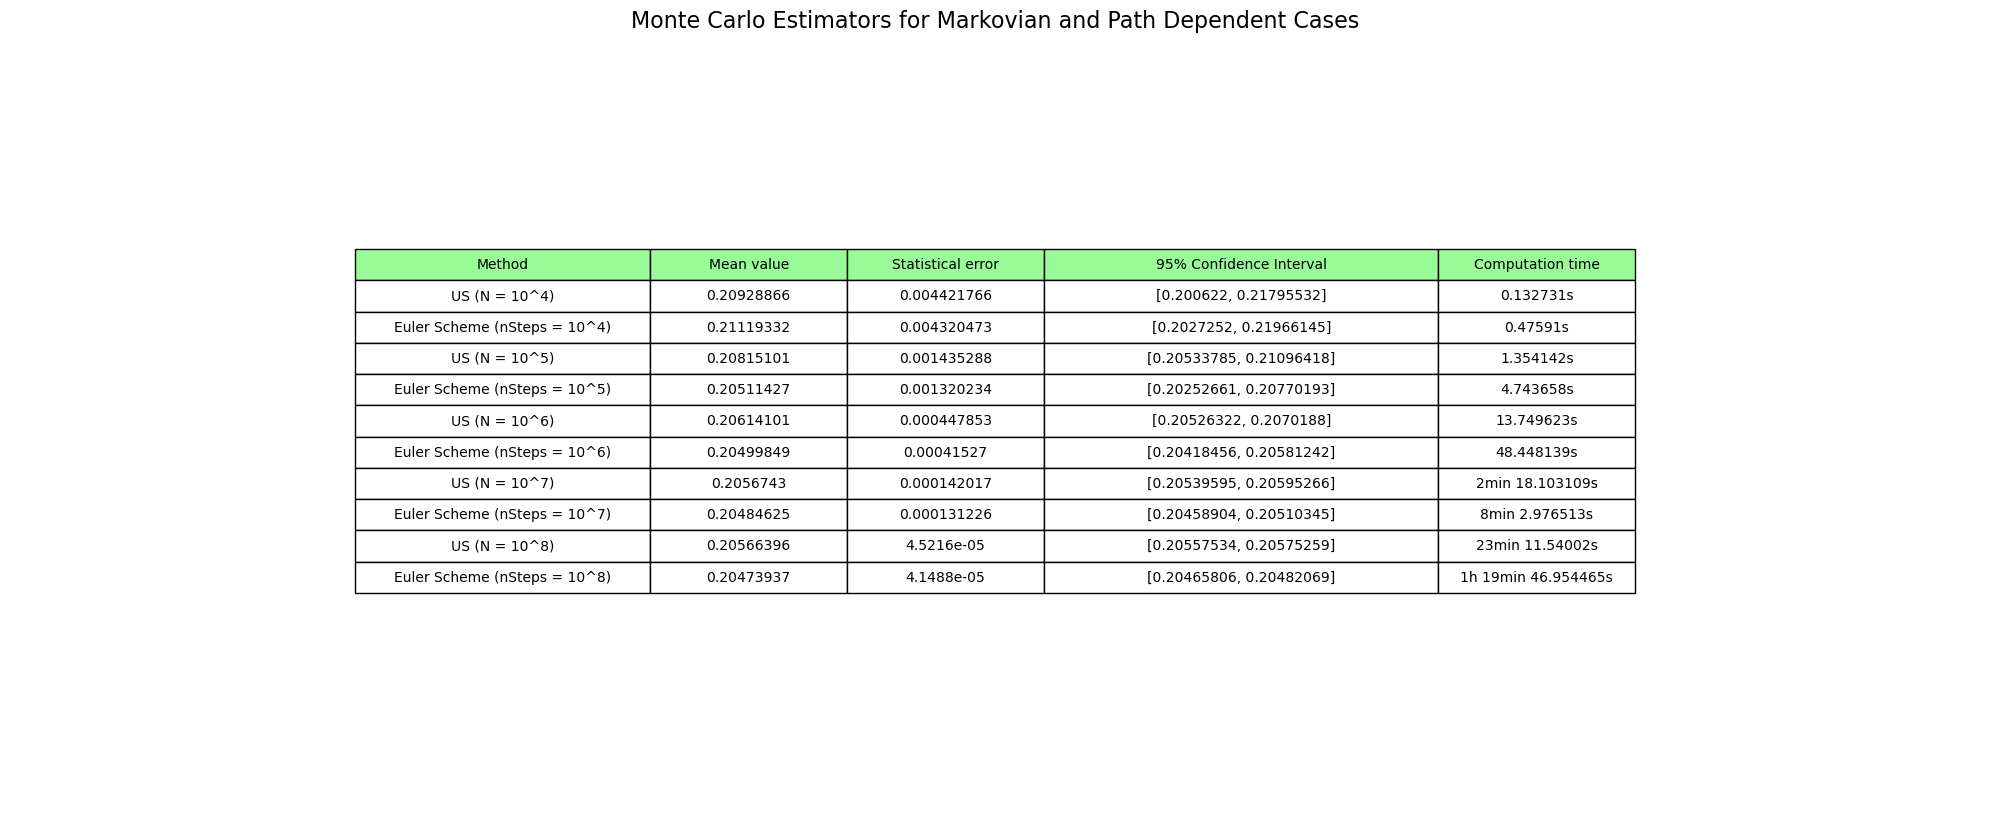

In [14]:
Method = []
Mean_value = []
conf_interval = []
statistical_error = []
Computation_time = []
Estimated_bias = []
for i in range(4, 9):
    nSamples = 10 ** i

    start_time = time.time()
    estimator, confidence_interval, error = markovian_case.MC_estimator(funcG, X0, funcMu, Sigma0, Beta, T, nDim, nSamples)
    Computation_time.append(time.time() - start_time)
    Mean_value.append(estimator)
    conf_interval.append(confidence_interval)
    statistical_error.append(error)
    Method.append(f"US (N = 10^{i})")

    start_time = time.time()
    estimator, confidence_interval, error = euler_scheme.MC_estimator_EulerScheme_Markovian(funcG, X0, funcMu, Sigma0, T, nDim, mSteps, nSamples)
    Computation_time.append(time.time() - start_time)
    Mean_value.append(estimator)
    conf_interval.append(confidence_interval)
    statistical_error.append(error)
    Method.append(f"Euler Scheme (nSteps = 10^{i})")

for i in range(len(Mean_value)):
    Estimated_bias.append(Mean_value[i] - Mean_value[-2])


rounded_mean_value = [round(val, 8) for val in Mean_value]
rounded_statistical_error = [round(val, 9) for val in statistical_error]
formatted_computation_time = [convert_to_hms(val) for val in Computation_time]
formatted_conf_interval = [f"[{round(ci[0], 8)}, {round(ci[1], 8)}]" for ci in conf_interval]
rounded_Estimated_bias = [round(val, 9) for val in Estimated_bias]

data = {
    'Method': Method,
    'Mean value': rounded_mean_value,
    'Statistical error': rounded_statistical_error,
    '95% Confidence Interval': formatted_conf_interval,
    'Computation time': formatted_computation_time
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(20, 8)) 
ax.axis('off')
colWidths = [0.15, 0.1, 0.1, 0.2, 0.1]
the_table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     loc='center',
                     cellLoc='center',
                     colColours=["palegreen"] * len(df.columns),
                     colWidths=colWidths)

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1, 1.5)
plt.tight_layout()
plt.title("Monte Carlo Estimators for Markovian and Path Dependent Cases", fontsize=16)
plt.show()

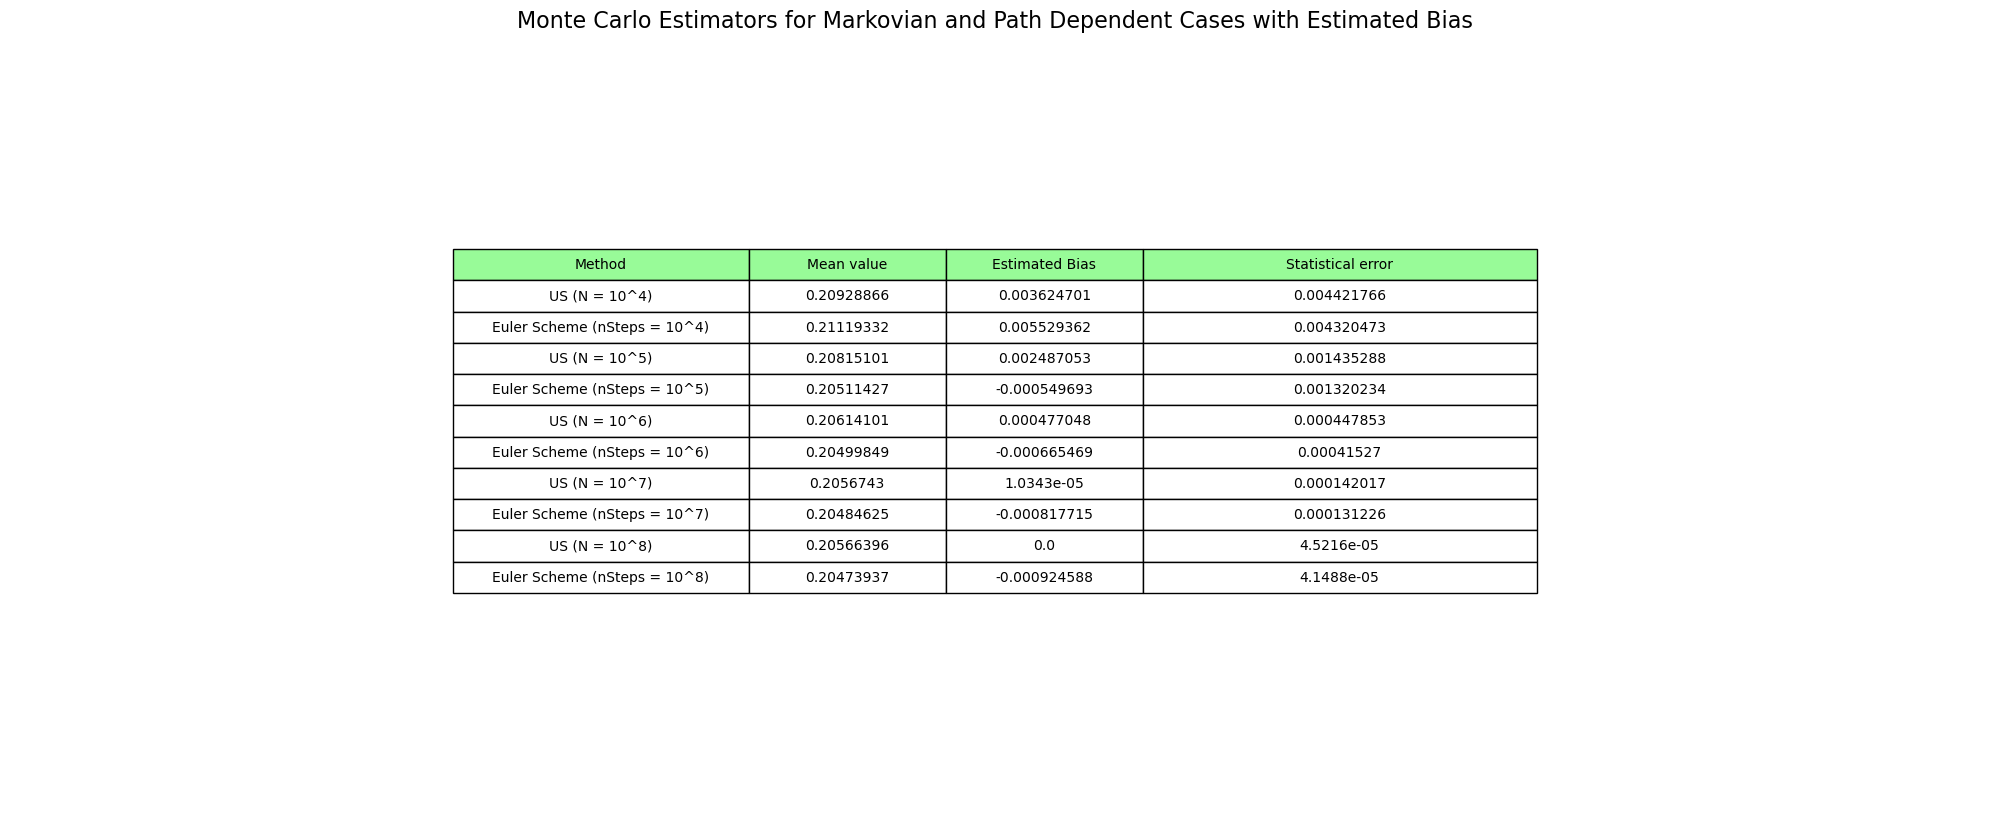

In [15]:
data = {
    'Method': Method,
    'Mean value': rounded_mean_value,
    'Estimated Bias': rounded_Estimated_bias,
    'Statistical error': rounded_statistical_error,
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(20, 8))

ax.axis('off')

colWidths = [0.15, 0.1, 0.1, 0.2, 0.1]

the_table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     loc='center',
                     cellLoc='center',
                     colColours=["palegreen"] * len(df.columns),
                     colWidths=colWidths)

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

the_table.scale(1, 1.5)

plt.tight_layout()
plt.title("Monte Carlo Estimators for Markovian and Path Dependent Cases with Estimated Bias", fontsize=16)
plt.show()

TEST for V_0_tilde in (4.2) from [Unbiased simulation of stochastic differential equations](https://arxiv.org/abs/1504.06107)

expected result : 0.1267 around

In [17]:
# Parameters:

Beta = 0.05 # Beta constant
lTimeIntervals = [i*T/10 for i in range(0, 11)]

# We adapt the new path dependent payoff to the example
def funcG_PathDep (lX):
    return np.maximum(0, np.sum(np.exp(lX))/len(lX) - K)

Run The Simulations

In [21]:
start_time = time.time()
estimator, confidence_interval, error = euler_scheme.MC_estimator_EulerScheme_Pathdep(funcG_PathDep, X0, funcMu, Sigma0, T, mSteps, nSamples, lTimeIntervals)
print("Estimator MC_estimator_EulerScheme_Pathdep:", estimator)
print("95% Confidence Interval MC_EulerScheme_Pathdep_Example::", confidence_interval)
print("Standard Error MC_EulerScheme_Pathdep_Example::", error)
print(f"Execution time: {time.time() - start_time} seconds")
print(" ")

Estimator MC_estimator_EulerScheme_Pathdep: 0.1261163872942953
95% Confidence Interval MC_EulerScheme_Pathdep_Example:: [0.1260708873600155, 0.1261618872285751]
Standard Error MC_EulerScheme_Pathdep_Example:: 2.3214252183564645e-05
Execution time: 5526.0459587574005 seconds
 


In [19]:
start_time = time.time()
estimator, confidence_interval, error = path_dependent_case.MC_estimator(funcG_PathDep, X0, funcMu, Sigma0, Beta, lTimeIntervals, nSamples)
print("Estimator US_Path_Dependent_Case:", estimator)
print("95% Confidence Interval US_Path_Dependent_Case:", confidence_interval)
print("Standard Error US_Path_Dependent_Case:", error)
print(f"Execution time: {time.time() - start_time} seconds")
print(" ")

Estimator US_Path_Dependent_Case: 0.12661059792322132
95% Confidence Interval US_Path_Dependent_Case: [0.12654915595842436, 0.12667203988801828]
Standard Error US_Path_Dependent_Case: 3.134794122294047e-05
Execution time: 12081.554850578308 seconds
 


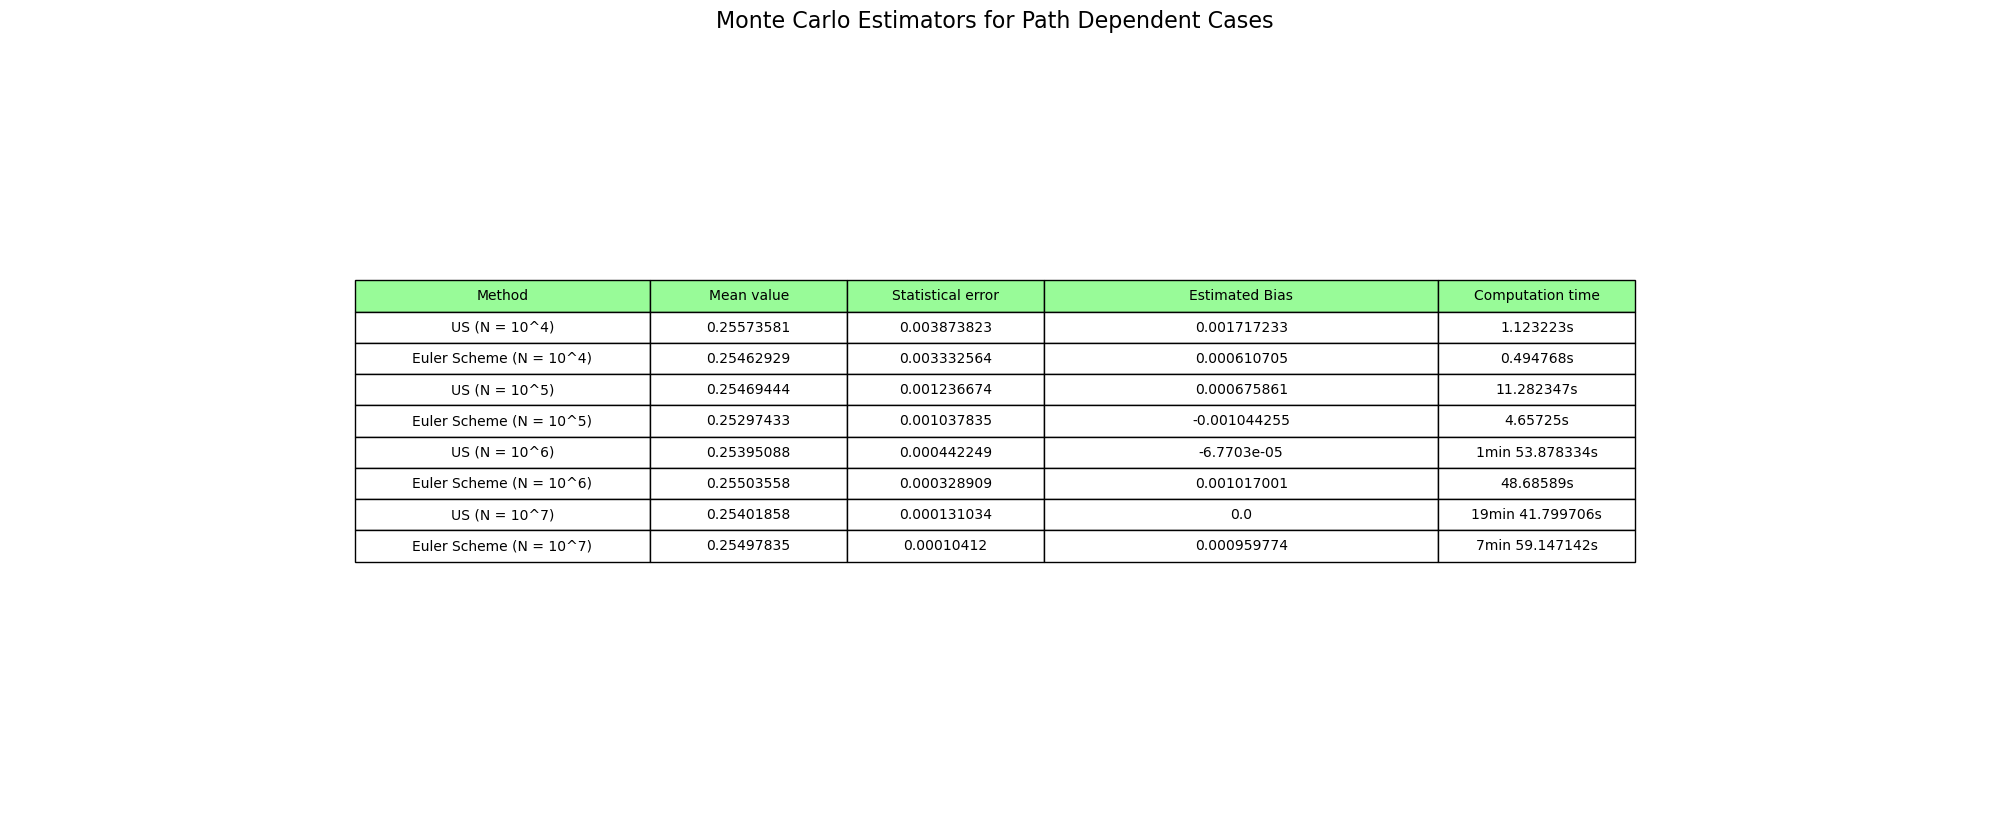

In [27]:
Method = []
Mean_value = []
#conf_interval = []
statistical_error = []
Computation_time = []
Estimated_bias = []
for i in range(4, 8):
    nSamples = 10 ** i

    start_time = time.time()
    estimator, confidence_interval, error = path_dependent_case.MC_estimator(funcG_PathDep, X0, funcMu, Sigma0, Beta, lTimeIntervals, nSamples)
    Computation_time.append(time.time() - start_time)
    Mean_value.append(estimator)
    #conf_interval.append(confidence_interval)
    statistical_error.append(error)
    Method.append(f"US (N = 10^{i})")

    start_time = time.time()
    estimator, confidence_interval, error = euler_scheme.MC_estimator_EulerScheme_Pathdep(funcG_PathDep, X0, funcMu, Sigma0, T, mSteps, nSamples, lTimeIntervals)
    Computation_time.append(time.time() - start_time)
    Mean_value.append(estimator)
    #conf_interval.append(confidence_interval)
    statistical_error.append(error)
    Method.append(f"Euler Scheme (N = 10^{i})")

for i in range(len(Mean_value)):
    Estimated_bias.append(Mean_value[i] - Mean_value[-2])

rounded_mean_value = [round(val, 8) for val in Mean_value]
rounded_statistical_error = [round(val, 9) for val in statistical_error]
formatted_computation_time = [convert_to_hms(val) for val in Computation_time]
rounded_Estimated_bias = [round(val, 9) for val in Estimated_bias]
#formatted_conf_interval = [f"[{round(ci[0], 8)}, {round(ci[1], 8)}]" for ci in conf_interval]

data = {
    'Method': Method,
    'Mean value': rounded_mean_value,
    'Statistical error': rounded_statistical_error,
    'Estimated Bias': rounded_Estimated_bias,
    'Computation time': formatted_computation_time
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(20, 8))

ax.axis('off')

colWidths = [0.15, 0.1, 0.1, 0.2, 0.1]

the_table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     loc='center',
                     cellLoc='center',
                     colColours=["palegreen"] * len(df.columns),
                     colWidths=colWidths)

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

the_table.scale(1, 1.5)
plt.tight_layout()

plt.title("Monte Carlo Estimators for Path Dependent Cases", fontsize=16)
plt.show()

TEST for V_0 in (4.3) from [Unbiased simulation of stochastic differential equations](https://arxiv.org/abs/1504.06107)

 - Building the graph of Computation time and Variance with Beta

In [23]:
# Parameters

X0 = 0  # Initial value
T = 1   # Maturity
nDim = 1    # Dim of process
mSteps = 10 # Number of time steps in Euler Scheme
nSamples = 10**5   # Number of simulations of MC

Sigma0 = 0.5

In [24]:
# Payoff G in the provided example sin(X_T)
def funcG(x):
    return np.sin(x)
# μ in the provided SDE
def funcMu(t, x):
    return 0.2 * np.cos(x)

<Figure size 640x480 with 0 Axes>

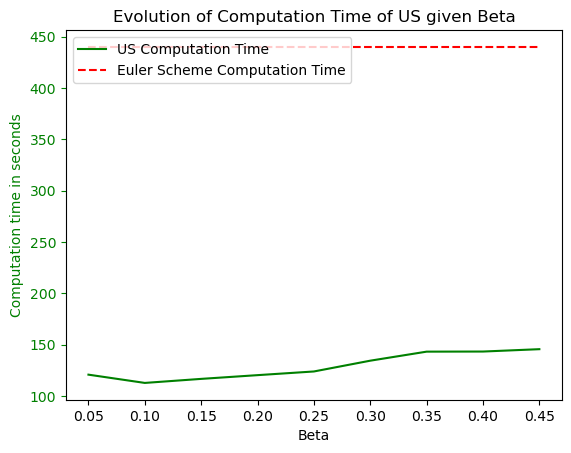

In [ ]:
#beta_values = [0.025*i for i in range(1, 250, 2)] #0.025
#beta_values = [0.05*i for i in range(1, 10)]
beta_values = [0.005*i for i in range(1, 101)]

US_CompTime = []
EulerScheme_CompTime = []
US_Var = []
EulerScheme_Var = []

start_time = time.time()
estimator, confidence_interval, error = euler_scheme.MC_estimator_EulerScheme_Markovian(funcG, X0, funcMu, Sigma0, T, nDim, mSteps, nSamples)
EulerScheme_t = time.time() - start_time
EulerScheme_Var.append((error*np.sqrt(nSamples))**2)

for beta in beta_values:
    start_time = time.time()
    estimator, confidence_interval, error = markovian_case.MC_estimator(funcG, X0, funcMu, Sigma0, beta, T, nDim, nSamples)
    US_CompTime.append(time.time() - start_time)
    US_Var.append((error*np.sqrt(nSamples))**2)
    EulerScheme_CompTime.append(EulerScheme_t)

    estimator, confidence_interval, error = euler_scheme.MC_estimator_EulerScheme_Markovian(funcG, X0, funcMu, Sigma0, T, nDim, mSteps, nSamples)
    EulerScheme_Var.append((error*np.sqrt(nSamples))**2)

plt.clf()

fig, ax1 = plt.subplots()

ax1.plot(beta_values, US_CompTime, 'g-', label='US Computation Time')
ax1.set_xlabel('Beta')
ax1.set_ylabel('Computation time in seconds', color='g')
ax1.tick_params('y', colors='g')

ax1.plot(beta_values, EulerScheme_CompTime, 'r--', label='Euler Scheme Computation Time')

ax1.legend(loc='upper left')

plt.title('Evolution of Computation Time of US given Beta')

plt.show()

<Figure size 640x480 with 0 Axes>

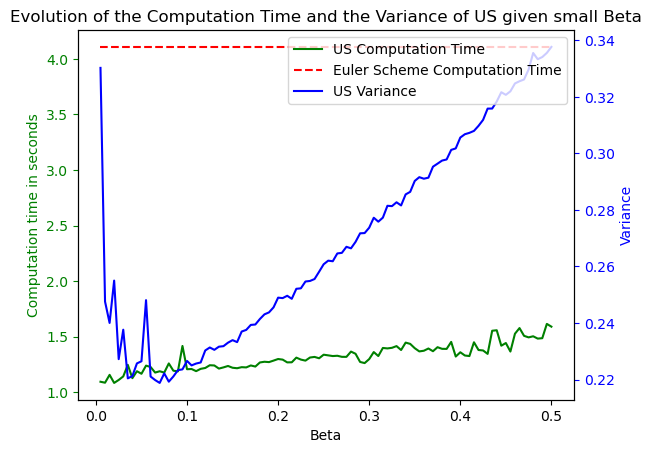

In [31]:
plt.clf()
fig, ax1 = plt.subplots()

ax1.plot(beta_values, US_CompTime, 'g-', label='US Computation Time')
ax1.set_xlabel('Beta')
ax1.set_ylabel('Computation time in seconds', color='g')
ax1.plot(beta_values, EulerScheme_CompTime, 'r--', label='Euler Scheme Computation Time')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(beta_values, US_Var, 'b-', label='US Variance')
# ax2.plot(beta_values, EulerScheme_Var[:len(beta_values)], 'r-', label='Euler Scheme Variance')
ax2.set_ylabel('Variance', color='b')
ax2.tick_params('y', colors='b')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')


plt.title('Evolution of the Computation Time and the Variance of US given small Beta')
plt.show()